In [29]:
#NB based on https://www.kaggle.com/code/quadeer15sh/flickr8k-image-captioning-using-cnns-lstms

#Import and loading data
import pandas as pd
import cv2 
import os

N_LOAD = 3000
captions = pd.read_csv("/kaggle/input/flickr8k/captions.txt")[:N_LOAD]
paths = captions.image.tolist()
captions.image = [cv2.imread(os.path.join("/kaggle/input/flickr8k/Images", path)) for path in captions.image]
captions.head()

,image,caption
0,"[[[77, 56, 58], [130, 131, 115], [117, 123, 10...",A child in a pink dress is climbing up a set o...
1,"[[[77, 56, 58], [130, 131, 115], [117, 123, 10...",A girl going into a wooden building .
2,"[[[77, 56, 58], [130, 131, 115], [117, 123, 10...",A little girl climbing into a wooden playhouse .
3,"[[[77, 56, 58], [130, 131, 115], [117, 123, 10...",A little girl climbing the stairs to her playh...
4,"[[[77, 56, 58], [130, 131, 115], [117, 123, 10...",A little girl in a pink dress going into a woo...


In [30]:
#Standardizing images
IMG_SIZE = 224

def transform(img):
    img = cv2.convertScaleAbs(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

captions.image = [transform(img) for img in captions.image]

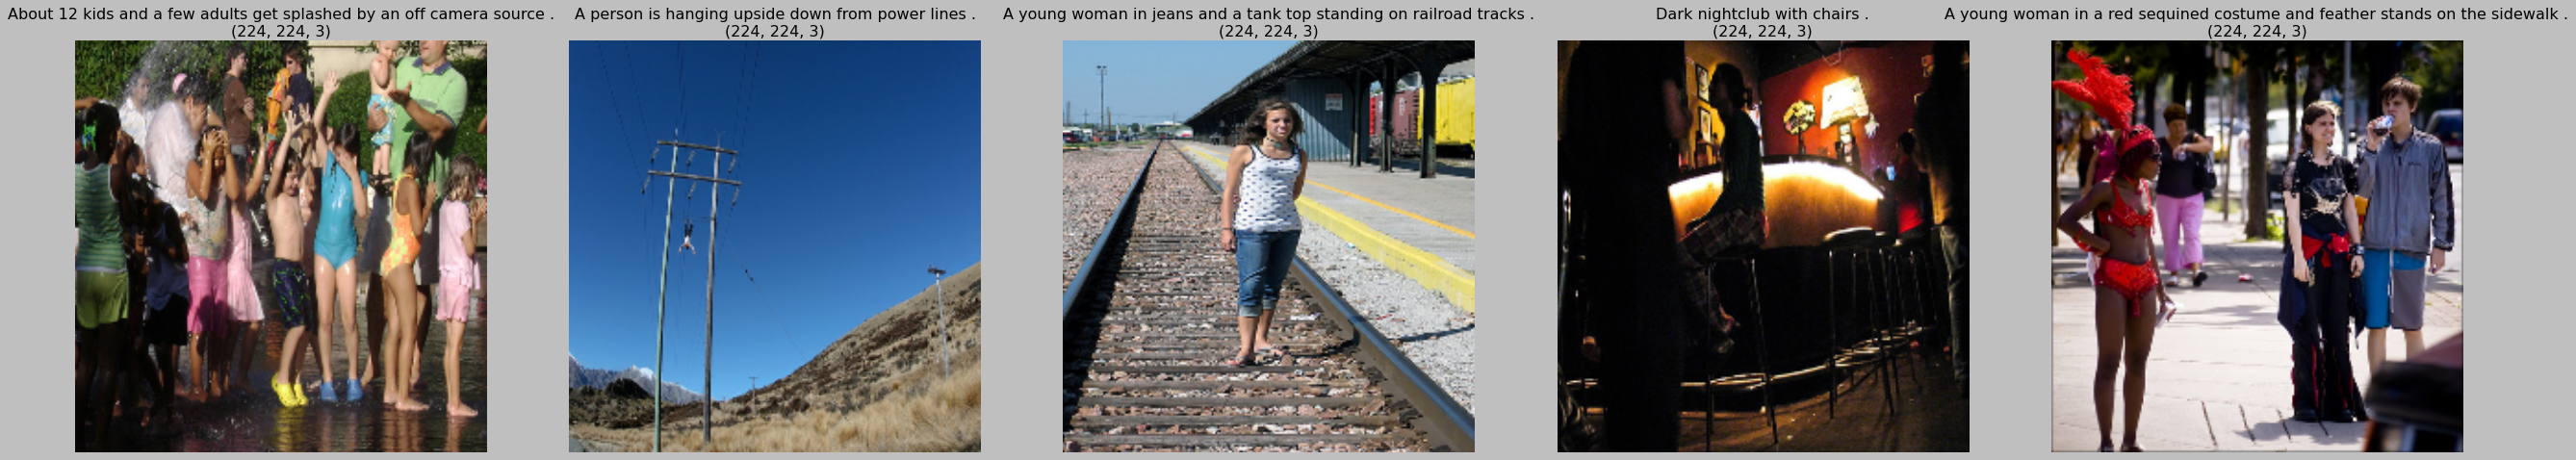

In [31]:
#Sampling images to look at
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("classic")
N_IMAGES = 5
plt.figure(figsize = [40, 40])

for n in range(N_IMAGES):
    rand_idx = np.random.choice(captions.index)
    image = captions.image[rand_idx]
    title = captions.caption[rand_idx]
    
    plt.subplot(1, N_IMAGES, n + 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"{title}\n{image.shape}")

plt.show()

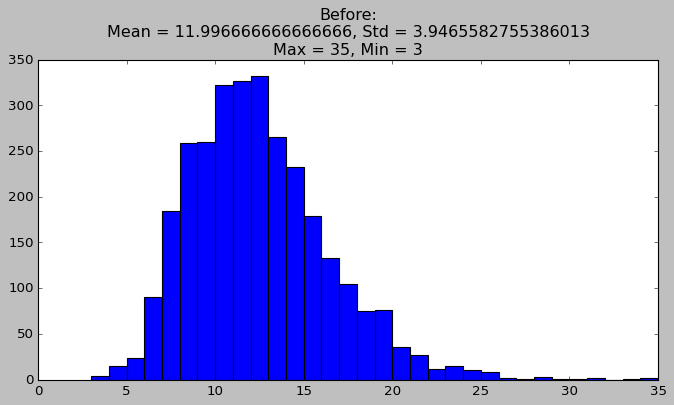

(2837, 2)


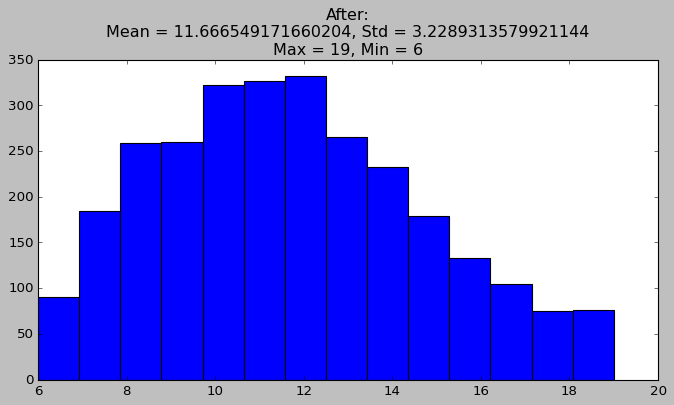

In [32]:
#Looking at captions and adjusting

caption_lengths = [len(sentence.split(" ")) for sentence in captions.caption]
plt.figure(figsize = [10, 5])
plt.hist(caption_lengths, bins = len(np.unique(caption_lengths)))
plt.title(f"Before:\nMean = {np.mean(caption_lengths)}, Std = {np.std(caption_lengths)}\nMax = {np.max(caption_lengths)}, Min = {np.min(caption_lengths)}")
plt.show()




criteria = lambda sentence : len(sentence.split(" ")) <= np.mean(caption_lengths) + 2*np.std(caption_lengths) and len(sentence.split(" ")) > 5
to_drop = []
for row in captions.index:
    if not criteria(captions.caption[row]):
        to_drop.append(row)
    
captions = captions.drop(to_drop, axis = 0)
print(captions.shape)




caption_lengths = [len(sentence.split(" ")) for sentence in captions.caption]
plt.figure(figsize = [10, 5])
plt.hist(caption_lengths, bins = len(np.unique(caption_lengths)))
plt.title(f"After:\nMean = {np.mean(caption_lengths)}, Std = {np.std(caption_lengths)}\nMax = {np.max(caption_lengths)}, Min = {np.min(caption_lengths)}")
plt.show()

In [33]:
#Text vectorization and making training and testing data
import tensorflow as tf

SEQLEN = int(np.max([len(sentence.split(" ")) for sentence in captions.caption]))
VOCAB_SIZE = 10000

captions.caption = [f"sos {sentence} eos" for sentence in captions.caption]

vectorizer = tf.keras.layers.TextVectorization(max_tokens = VOCAB_SIZE, standardize = "lower_and_strip_punctuation", output_sequence_length = SEQLEN)
vectorizer.adapt(captions.caption)
print("Vocab Length: ", len(vectorizer.get_vocabulary()))
print("Vocab: ", vectorizer.get_vocabulary()[-10:])

n_slices = 100
slice_size = captions.shape[0] // n_slices
train = captions.iloc[: (n_slices - 2) * slice_size]
val = captions.iloc[(n_slices - 2) * slice_size: (n_slices - 1) * slice_size]
test = captions.iloc[(n_slices - 1) * slice_size :]
img_train = train.image.tolist(); capt_train = train.caption.tolist()
img_test = test.image.tolist(); capt_test = test.caption.tolist()
img_val = val.image.tolist(); capt_val = val.caption.tolist()



#Making a method to generate additional data for next word
def generate_next_word_data(img, capts):
    img_list, capt_x, capt_y = [], [], []
    for image, caption in zip(img, capts):
        caption = " ".join([i for i in caption.split(" ") if len(i) > 1]) #Removing all one letter words
        full_caption = vectorizer("sos " + caption + " eos").numpy()
        
        #Split either near beginning or near end
        split_idx = 1
        n_sentences = len([i for i in full_caption if i != 0])
        for _ in range(n_sentences - 1):    
            img_list.append(image)
            capt_x.append(np.concatenate([full_caption[:split_idx], np.array([0 for _ in full_caption[split_idx:]])]))
            capt_y.append(full_caption[split_idx])
            split_idx = split_idx + 1
            
    return np.array(img_list), np.array(capt_x), np.array(capt_y), capts

img_train, capt_train_x, capt_train_y, _ = generate_next_word_data(img_train, capt_train)
img_test, capt_test_x, capt_test_y, test_captions = generate_next_word_data(img_test, capt_test)
img_val, capt_val_x, capt_val_y, _ = generate_next_word_data(img_val, capt_val)

VOCAB_SIZE = len(vectorizer.get_vocabulary())

Vocab Length:  2324
Vocab:  ['age', 'africanamerican', 'aerodynamic', 'ad', 'active', 'acting', '7', '5', '2', '12']


In [34]:
img_train.shape, capt_train_x.shape, capt_train_y.shape

((33200, 224, 224, 3), (33200, 19), (33200,))

In [35]:
#Preparing datasets

train_ds = tf.data.Dataset.from_tensor_slices(((img_train, capt_train_x), capt_train_y))
test_ds = tf.data.Dataset.from_tensor_slices(((img_test, capt_test_x), capt_test_y))
val_ds = tf.data.Dataset.from_tensor_slices(((img_val, capt_val_x), capt_val_y))

BATCH_SIZE = 32

train_ds = train_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [36]:
#Trying both an RNN and Attention-based decoder 

'''
Things to try from other notebook:
- Use VGG16.preprocess_input layer
- There are duplicate captions for each image in the data
- Removed all words less than 1 (to maybe filter general stop words)
- Didn't limit caption lengths to an upper bound
- Output was next word, not whole sentence
'''

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

feature_extractor = EfficientNetB0(input_shape = (IMG_SIZE, IMG_SIZE, 3))
pretrained = tf.keras.models.Model(inputs = feature_extractor.input, outputs = feature_extractor.layers[-2].output)
for layer in pretrained.layers:
    layer.trainable = False
    
image_input = tf.keras.layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
pretrained_out = preprocess_input(image_input)
pretrained_out = pretrained(pretrained_out)
pretrained_out = tf.keras.layers.Dropout(0.2)(pretrained_out)
pretrained_out = tf.keras.layers.Dense(512, activation = 'relu')(pretrained_out)
pretrained_out = tf.keras.layers.Reshape((16, 32))(pretrained_out)

caption_input = tf.keras.layers.Input(shape = (SEQLEN, ))
embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 512, mask_zero = True)(caption_input)
embedding = tf.keras.layers.Dropout(0.2)(embedding)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences = True))(embedding)
lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(lstm)
lstm = tf.keras.layers.Reshape((16, 32))(lstm)


concat = tf.keras.layers.Concatenate()([pretrained_out, lstm])
concat = tf.keras.layers.LayerNormalization()(concat)
concat = tf.keras.layers.LSTM(256)(concat)
add = tf.keras.layers.Dense(256, activation = 'relu')(concat)
results = tf.keras.layers.Dense(VOCAB_SIZE, activation = 'softmax')(add)

model = tf.keras.models.Model((image_input, caption_input), results)

In [37]:
#Compiling the model

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 19, 512)   │  1,189,888 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 1280)      │  4,049,571 │ input_layer_4[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 19, 512)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 19)        │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1280)      │          0 │ functional_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 19, 512)   │  1,574,912 │ dropout_3[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    655,872 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 512)       │  1,574,912 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 16, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 16, 32)    │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 64)    │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 16, 64)    │        128 │ concatenate_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    328,704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2324)      │    597,268 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,037,047 (38.29 MB)

 Trainable params: 5,987,476 (22.84 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10


2024-07-19 01:04:42.718937: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_7_1/functional_5_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 111s 87ms/step - accuracy: 0.2432 - loss: 4.8949 - val_accuracy: 0.2602 - val_loss: 4.5985
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 86s 83ms/step - accuracy: 0.3210 - loss: 3.9112 - val_accuracy: 0.3070 - val_loss: 4.4233
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step - accuracy: 0.3372 - loss: 3.5982 - val_accuracy: 0.3187 - val_loss: 4.4373
Epoch 4/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 86s 82ms/step - accuracy: 0.3537 - loss: 3.3974 - val_accuracy: 0.3304 - val_loss: 4.3604
Epoch 5/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.3750 - loss: 3.1879 - val_accuracy: 0.3480 - val_loss: 4.2602
Epoch 6/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.3931 - loss: 3.0093 - val_accuracy: 0.3538 - val_loss: 4.3289
Epoch 7/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.4054 - loss: 2.8450 - val_accuracy: 0.3450 - val_loss: 4.5185
Epoch 8/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 85s 82ms/step - accuracy: 0.4197 - loss: 2.6

[5.045052528381348, 0.3782051205635071]

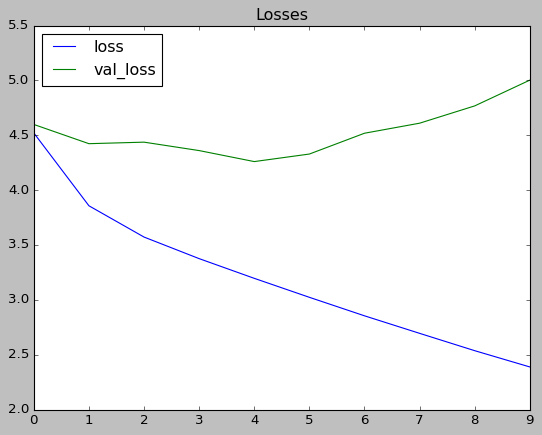

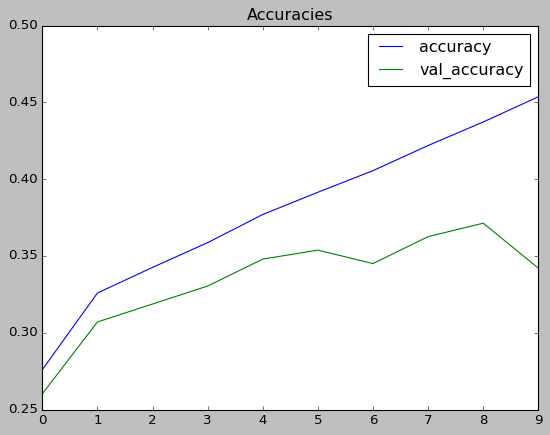

In [38]:
#Fitting

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.1, patience = 10)
]

hist = model.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks = callbacks).history
pd.DataFrame(hist)[['loss', 'val_loss']].plot(title = "Losses")
pd.DataFrame(hist)[['accuracy', 'val_accuracy']].plot(title = "Accuracies")

model.evaluate(test_ds)

In [39]:
#Method for beam search
import time
from concurrent.futures import ThreadPoolExecutor
from threading import Lock

def beam_search(previous, k, img, n_repetitions = 0): #[[sentence, score]]
    branches = []
    count_eos = 0
    max_score = 0
    best_sentence = ""
    lock = Lock()
    
    start = time.time()
    
    
    def process_sentence(sentence, sentence_score):
        if 'eos' in sentence:
            with lock:
                branches.append([sentence, sentence_score])
                count_eos += 1
                if sentence_score > max_score:
                    max_score = sentence_score
                    best_sentence = sentence
        else:
            pred = model.predict((np.expand_dims(img, 0), np.expand_dims(vectorizer(sentence), 0)), verbose=0)[0]
            top_k_indices = np.argsort(pred)[-1 * k:]
            with lock:
                for idx in top_k_indices:
                    new_sentence = sentence + " " + vectorizer.get_vocabulary()[idx]
                    new_sentence_score = sentence_score + pred[idx]
                    branches.append([new_sentence, new_sentence_score])
    
    
    
    with ThreadPoolExecutor(max_workers = len(previous)) as e:
        for sentence, sentence_score in previous:
            e.submit(process_sentence, sentence, sentence_score)
        
                
    end = time.time()
    
    print(f"Rounds of beam search done: {n_repetitions} in {end - start}s")
    if count_eos == len(previous):
        return best_sentence
    elif n_repetitions > 5:
        best_idx = np.argsort([pair[1] for pair in branches])[-1]
        return branches[best_idx][0]
    else:
        return beam_search(branches, k, img, n_repetitions + 1)
        

Rounds of beam search done: 0 in 3.057196617126465s
Rounds of beam search done: 1 in 0.20664525032043457s
Rounds of beam search done: 2 in 0.5574338436126709s
Rounds of beam search done: 3 in 1.7059693336486816s
Rounds of beam search done: 4 in 5.2894697189331055s
Rounds of beam search done: 5 in 17.321757555007935s
Rounds of beam search done: 6 in 52.79494667053223s


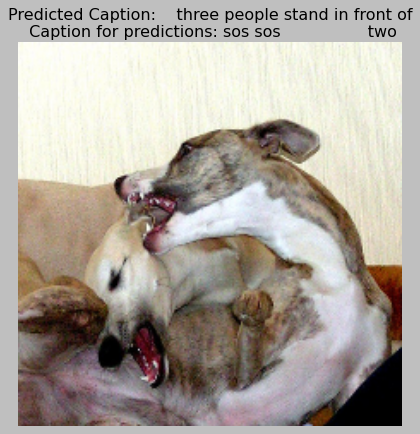

In [40]:
#Predicting

rand_idx = np.random.randint(0, len(img_test)) - 10
image = img_test[rand_idx]
caption_head = " ".join([vectorizer.get_vocabulary()[i] for i in capt_test_x[rand_idx]])
caption_next_word = vectorizer.get_vocabulary()[capt_test_y[rand_idx]]

predicted_sentence = beam_search([["sos ", 0.0]], 3, image)


predicted_sentence = predicted_sentence.replace("sos", "").replace("eos", "")

plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Caption: {predicted_sentence}\n Caption for predictions: {caption_head + caption_next_word}")
plt.show()

Rounds of beam search done: 0 in 0.13596343994140625s
Rounds of beam search done: 1 in 0.21216678619384766s
Rounds of beam search done: 2 in 0.5663232803344727s
Rounds of beam search done: 3 in 1.6784965991973877s
Rounds of beam search done: 4 in 5.225640296936035s
Rounds of beam search done: 5 in 16.85762596130371s
Rounds of beam search done: 6 in 50.515827655792236s


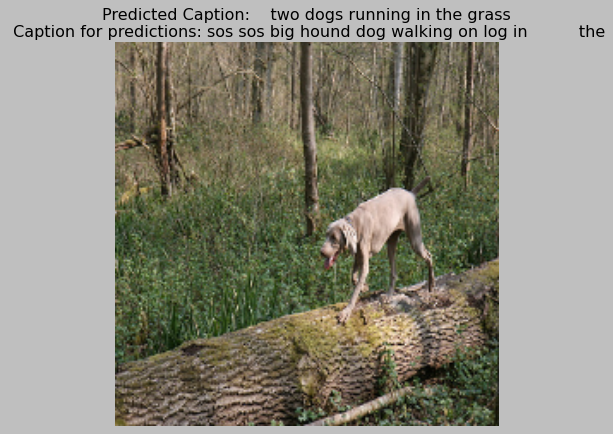

In [41]:
#Predicting again

rand_idx = np.random.randint(0, len(img_test)) - 10
image = img_test[rand_idx]
caption_head = " ".join([vectorizer.get_vocabulary()[i] for i in capt_test_x[rand_idx]])
caption_next_word = vectorizer.get_vocabulary()[capt_test_y[rand_idx]]

predicted_sentence = beam_search([["sos ", 0.0]], 3, image)


predicted_sentence = predicted_sentence.replace("sos", "").replace("eos", "")

plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted Caption: {predicted_sentence}\n Caption for predictions: {caption_head + caption_next_word}")
plt.show()